Reproduction [Quantifying Trading Behavior in Financial Markets Using Google Trends](http://www.nature.com/srep/2013/130425/srep01684/pdf/srep01684.pdf)
==============================================

The first part of this tutorial covered the basics of `Pandas` and how to use it for analyzing financial data.

In the second part we will reiterate these concepts by applying them to reproduce a paper published recently on using Google Trends search volume for specific terms (e.g. 'debt') to predict market movements. Several cells are left blank for you to fill in.

In addition, we will see how we can test an actual trading strategy using `Pandas` and calculate its performance.

In [1]:
from IPython.core.display import HTML
HTML("<iframe src=http://www.nature.com/srep/2013/130425/srep01684/full/srep01684.html width=900 height=400></iframe>")

In [3]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rc('figure', figsize=(8, 7))

Tobias Preis was kind enough to provide me with the data used in this publication. There are many Google Trends search words but here we will only be using 'debt'.

In [6]:
data = pd.read_csv('../data/GoogleTrendsData.csv', index_col='Date', parse_dates=True)
data.head()

,djia,debt
Date,,
2004-01-14,10485.18,0.210000
2004-01-22,10528.66,0.210000
2004-01-28,10702.51,0.210000
2004-02-04,10499.18,0.213333
2004-02-11,10579.03,0.200000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000CD90E48>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000DC48438>], dtype=object)

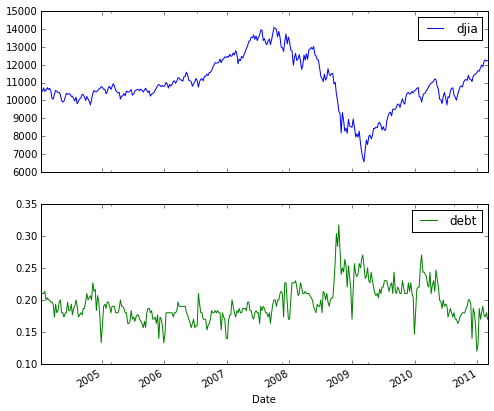

In [7]:
data.plot(subplots=True)

The authors detect if search volume is relatively increasing or decreasing in any given week by forming a moving average and testing if the current value crosses the moving average of the past 3 weeks. 

Lets first compute the moving average.

In [8]:
data['debt_mavg'] = pd.rolling_mean(data.debt, 3)
data.head()

,djia,debt,debt_mavg
Date,,,
2004-01-14,10485.18,0.210000,NaN
2004-01-22,10528.66,0.210000,NaN
2004-01-28,10702.51,0.210000,0.210000
2004-02-04,10499.18,0.213333,0.211111
2004-02-11,10579.03,0.200000,0.207778


Since we want to see if the current value is above the moving average of the *preceeding* weeks, we have to shift the moving average timeseries forward by one.

In [9]:
data['debt_mavg'] = data.debt_mavg.shift(1)
data.head(10)

,djia,debt,debt_mavg
Date,,,
2004-01-14,10485.18,0.210000,NaN
2004-01-22,10528.66,0.210000,NaN
2004-01-28,10702.51,0.210000,NaN
2004-02-04,10499.18,0.213333,0.210000
2004-02-11,10579.03,0.200000,0.211111
2004-02-19,10714.88,0.203333,0.207778
2004-02-25,10609.62,0.200000,0.205555
2004-03-03,10678.14,0.200000,0.201111
2004-03-10,10529.48,0.196667,0.201111


Generate the order signals.
===========================

From the paper:

"We use Google Trends to determine how many searches n(t – 1) have been carried out for a specific search term such as debt in week t – 1, where Google defines weeks as ending on a Sunday, relative to the total number of searches carried out on Google during that time."

and

"We implement this strategy by selling the DJIA at the closing price p(t) on the first trading day of week t, if Δn(t − 1, Δt) > 0, and buying the DJIA at price p(t + 1) at the end of the first trading day of the following week. [...]. If instead Δn(t − 1, Δt) < 0, then we buy the DJIA at the closing price p(t) on the first trading day of week t and sell the DJIA at price p(t + 1) at the end of the first trading day of the coming week."

In [10]:
data['order'] = 0
data['order'][data.debt > data.debt_mavg] = -1 # Short if search volume goes up relative to mavg.
data['order'][data.debt < data.debt_mavg] = 1 # Long if search volume goes down relative to mavg.
data.head(10)

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,djia,debt,debt_mavg,order
Date,,,,
2004-01-14,10485.18,0.210000,NaN,0
2004-01-22,10528.66,0.210000,NaN,0
2004-01-28,10702.51,0.210000,NaN,0
2004-02-04,10499.18,0.213333,0.210000,-1
2004-02-11,10579.03,0.200000,0.211111,1
2004-02-19,10714.88,0.203333,0.207778,1
2004-02-25,10609.62,0.200000,0.205555,1
2004-03-03,10678.14,0.200000,0.201111,1
2004-03-10,10529.48,0.196667,0.201111,1


Compute returns
===============

In [11]:
data['ret_djia'] = data.djia.pct_change()
data.head()

,djia,debt,debt_mavg,order,ret_djia
Date,,,,,
2004-01-14,10485.18,0.210000,NaN,0,NaN
2004-01-22,10528.66,0.210000,NaN,0,0.004147
2004-01-28,10702.51,0.210000,NaN,0,0.016512
2004-02-04,10499.18,0.213333,0.210000,-1,-0.018998
2004-02-11,10579.03,0.200000,0.211111,1,0.007605


Returns at week `t` are relative to week `t-1`. However, we are buying at week `t` and selling at week `t+1`, so we have to adjust by shifting the returns upward.

In [12]:
data['ret_djia'] = data['ret_djia'].shift(-1)

The algorithm that is used by the authors makes a decision every Monday of whether to long or short the Dow Jones. After this week passed, we exit all positions (sell if we longed, buy if we shorted) and make a new trading decision.

The `ret` column contains the weekly returns. Thus, if we buy at week `t` sell at week `t+1` we make the returns of week `t+1`. Conversely, if we short at week `t` and buy back at week `t+1` we make the negative returns of week `t+1`.

In [13]:
# Compute returns of our strategy
data['ret_google'] = data.order * data.ret_djia
data.head(10)

,djia,debt,debt_mavg,order,ret_djia,ret_google
Date,,,,,,
2004-01-14,10485.18,0.210000,NaN,0,0.004147,0.000000
2004-01-22,10528.66,0.210000,NaN,0,0.016512,0.000000
2004-01-28,10702.51,0.210000,NaN,0,-0.018998,-0.000000
2004-02-04,10499.18,0.213333,0.210000,-1,0.007605,-0.007605
2004-02-11,10579.03,0.200000,0.211111,1,0.012841,0.012841
2004-02-19,10714.88,0.203333,0.207778,1,-0.009824,-0.009824
2004-02-25,10609.62,0.200000,0.205555,1,0.006458,0.006458
2004-03-03,10678.14,0.200000,0.201111,1,-0.013922,-0.013922
2004-03-10,10529.48,0.196667,0.201111,1,-0.040514,-0.040514


Now we just have to compound the returns. As we are reinvesting our earns, returns actually do not compound by summing them up but by taking their cumulative product:

$$i_t = (i_{t-1} + i_{t-1} \cdot r_t) = (1 + r_t) \cdot i_{t-1}, \quad i_0 = 1$$

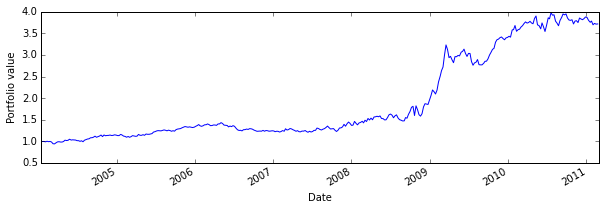

In [16]:
plt.figure().set_size_inches(10, 3)
(1 + data.ret_google).cumprod().plot();
plt.ylabel('Portfolio value')

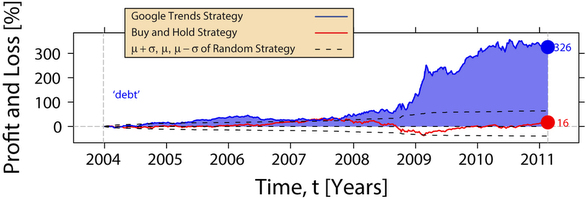

In [17]:
from IPython.core.display import Image 
Image("http://www.nature.com/srep/2013/130425/srep01684/carousel/srep01684-f2.jpg")

Limitations
-----------

We have seen that `Pandas` can do very flexible yet powerful processing of time-series financial data.

Using some basic financial math we can even implement a simple backtest.

However, there are many complexities involved if we actually wanted to run this strategy in the real world that we are neglecting here:

* Error prone
* Not taking transaction costs into account
* Slippage: Influence of our own orders on the price.
* Look-ahead bias: The whole history is available to us which makes it very easy to use information we would not have access to.

Thus, to really backtest a strategy properly we need to simulate all these things.

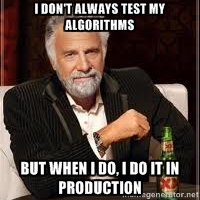

In [18]:
from IPython.core.display import Image 
Image("http://cdn.meme.li/instances/300x300/39833146.jpg")